In [2]:
from keras.datasets import fashion_mnist
from keras.utils import np_utils
from keras import callbacks as cb
from keras.optimizers import Adam
from keras.models import load_model

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
import random
%matplotlib inline

In [4]:
#自分のアラームを用意します
import helper.load_music as ld
import pygame
songs = ld.music_load(dir='Music_sample',length=8000)
song_test = songs[0].reshape(-1,2)
pygame.mixer.init(44100,-16,2)
sound = pygame.sndarray.make_sound(song_test)

In [5]:
label_data = {0:'T-shirt/top'
,1:'Trouser'
,2:'Pullover'
,3:'Dress'
,4:'Coat'
,5:'Sandal'
,6:'Shirt'
,7:'Sneaker'
,8:'Bag'
,9:'Ankle boot'}

In [6]:
#Import Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = np.expand_dims(x_train,3)/255., np.expand_dims(x_test,3)/255.
x_val, y_val = x_train[-5000:], y_train[-5000:]
x_train, y_train = x_train[:-5000], y_train[:-5000]
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((55000, 28, 28, 1),
 (55000,),
 (5000, 28, 28, 1),
 (5000,),
 (10000, 28, 28, 1),
 (10000,))

In [7]:
from keras.layers import *
from keras.models import Sequential
from keras import regularizers as rg
from keras.preprocessing.image import ImageDataGenerator

# 参考
- Random Erase
https://arxiv.org/abs/1708.04896
- 100%　消す確率は厳しすぎて25％に緩めておきます。

In [8]:
'''
Random Erase, from 28x28 size we will randomly
25% of chance to be erased
set 0 for 4x4 - 6x6 area
Input: 3-d tensor WxHxC(1)
'''
imsize = 28
def random_erase(x):
    prob = np.random.rand(1)[0]
    out = x.copy()
    if prob > 0.75:
        width, height = np.random.randint(4,6,2)
        wst, hst = random.randint(0,imsize-width),random.randint(0,imsize-height)
        out[wst:wst+width, hst:hst+height] = 0
    return out

In [9]:
transform = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    horizontal_flip = True,
    preprocessing_function = random_erase
)

val_trans = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True
)

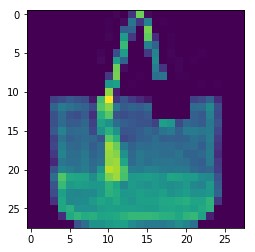

In [17]:
plt.imshow(random_erase(x_train[35][:,:,0]))

In [18]:
def show_image(im_data, label, sam_num):
    plt.title(label_data[label[sam_num]])
    plt.imshow(im_data[sam_num,:,:,0])

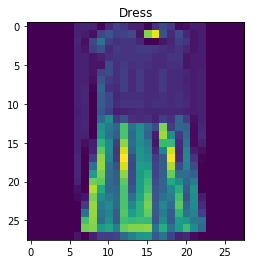

In [19]:
show_image(x_train, y_train, 251)

# モデル
データはそこまで複雑ではなくて、小さいモデルでも一応精度をとれると思います。
試行錯誤で悪くない精度をとれて、操りやすいモデルは以下の通りです。

In [20]:
feature_layers = [
    Conv2D(32,(2,2),padding='valid',activation='relu',input_shape=(28,28,1)),
    BatchNormalization(),
    MaxPooling2D(),
    Conv2D(128,(2,2),padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Flatten()
]

classify_layer = [
    Dense(128,activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64,activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(10,activation='softmax')
]

model = Sequential(feature_layers + classify_layer)

In [21]:
adam = Adam()
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 32)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

In [23]:
#Callback
reduce_lr = cb.ReduceLROnPlateau(factor=0.4,patience=2)
save_model = cb.ModelCheckpoint('model/fashion2', monitor='val_loss',save_best_only=True)
early_break = cb.EarlyStopping(patience=7)

# 正規化
練習データをもとに平均と偏差を求めます。

In [34]:
transform.fit(x_train)
val_trans.fit(x_train)

In [32]:
onehot = np_utils.to_categorical
train = model.fit_generator(transform.flow(x_train, onehot(y_train), batch_size=100),epochs=50,
                            validation_data=val_trans.flow(x_val, onehot(y_val)),callbacks=[reduce_lr,save_model,early_break])
#Alarm
sound.play()

Epoch 1/50
550/550 [==============================] - 31s 56ms/step - loss: 0.5693 - acc: 0.8045 - val_loss: 0.4094 - val_acc: 0.8582
Epoch 2/50
550/550 [==============================] - 19s 34ms/step - loss: 0.3788 - acc: 0.8682 - val_loss: 0.2789 - val_acc: 0.8968
Epoch 3/50
550/550 [==============================] - 19s 34ms/step - loss: 0.3212 - acc: 0.8888 - val_loss: 0.2462 - val_acc: 0.9096
Epoch 4/50
550/550 [==============================] - 19s 34ms/step - loss: 0.3005 - acc: 0.8929 - val_loss: 0.2464 - val_acc: 0.9100
Epoch 5/50
550/550 [==============================] - 19s 35ms/step - loss: 0.2790 - acc: 0.9008 - val_loss: 0.2605 - val_acc: 0.9042
Epoch 6/50
550/550 [==============================] - 19s 35ms/step - loss: 0.2604 - acc: 0.9085 - val_loss: 0.2330 - val_acc: 0.9128
Epoch 7/50
550/550 [==============================] - 19s 35ms/step - loss: 0.2509 - acc: 0.9104 - val_loss: 0.2281 - val_acc: 0.9194
Epoch 8/50
550/550 [==============================] - 19s 35ms

In [33]:
sound.stop()

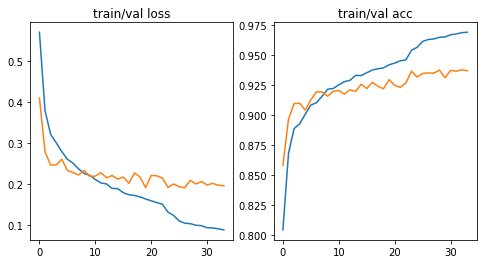

In [53]:
hist = train.history
fig, axes = plt.subplots(1,2,figsize=(8,4))
axes[0].plot(hist['loss'])
axes[0].plot(hist['val_loss'])
axes[0].set_title('train/val loss')
axes[1].plot(hist['acc'])
axes[1].plot(hist['val_acc'])
axes[1].set_title('train/val acc')
plt.show()

# model Evaluation

[test_loss, accuracy]

In [34]:
model.evaluate_generator(val_trans.flow(x_test, onehot(y_test)))

[0.22239811734706164, 0.93320000000000003]

# Display Result
From the test data

In [28]:
#Add number of the test data for each category
tag_data = {i:[] for i in range(10)}
for index,i in enumerate(y_test):
    tag_data[i].append(index)

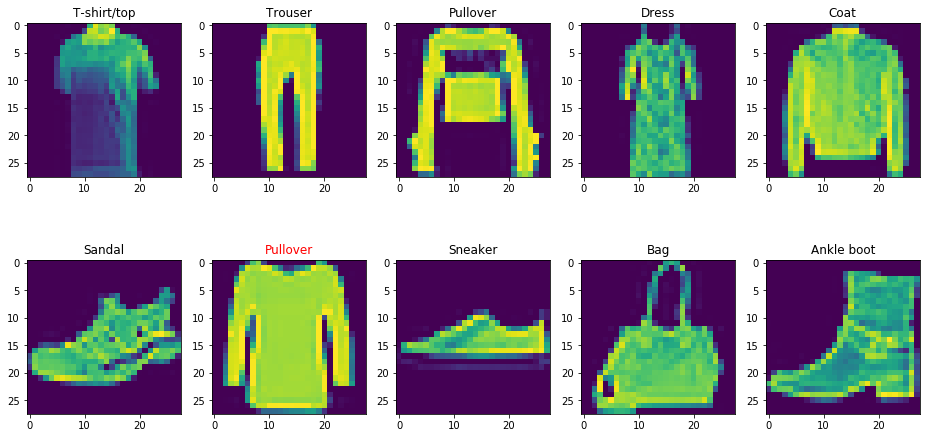

In [117]:
onehot = np_utils.to_categorical
to_show = np.zeros((10,28,28,1))
for cls in range(10):
    to_show[cls] = x_test[random.choice(tag_data[cls])]
pred = np.argmax(model.predict_generator(val_trans.flow(to_show,shuffle=False)),axis=1)
fig, axes = plt.subplots(2,5,figsize=(16,8))
count = 0
for row in axes:
    for axe in row:
        axe.imshow(to_show[count][:,:,0])
        color = 'black' if pred[count] == count else 'r'
        axe.set_title(label_data[pred[count]],color=color)
        count += 1